In [1]:
from blimpy import Waterfall
import numpy as np
import matplotlib.pyplot as plt
import itertools, json
from astropy.stats.sigma_clipping import sigma_clip
from scipy.optimize import curve_fit
from scipy.interpolate import make_splrep
import scipy
from scipy import signal

In [2]:
from blimpy import Waterfall

filename = 'Clipped.spliced_blc0001020304050607_guppi_57571_78180_HIP45653_0042.gpuspec.0002.h5'
fil = Waterfall(filename)

In [3]:
print(dir(fil))

['_Waterfall__load_data', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_blob_dimensions', '_get_chunk_dimensions', '_init_alternate', '_update_header', 'beam_axis', 'blank_dc', 'calc_n_coarse_chan', 'calibrate_band_pass_N1', 'container', 'data', 'ext', 'file_header', 'file_shape', 'file_size_bytes', 'filename', 'freq_axis', 'get_freqs', 'grab_data', 'header', 'info', 'logger', 'n_channels_in_file', 'n_ints_in_file', 'plot_all', 'plot_kurtosis', 'plot_spectrum', 'plot_spectrum_min_max', 'plot_time_series', 'plot_waterfall', 'read_data', 'selection_shape', 'stokes_axis', 'time_axis', 'write_to_fil', 'write_to_hdf5']


/home/long/anaconda3/lib/python3.12/site-packages/blimpy/utils.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


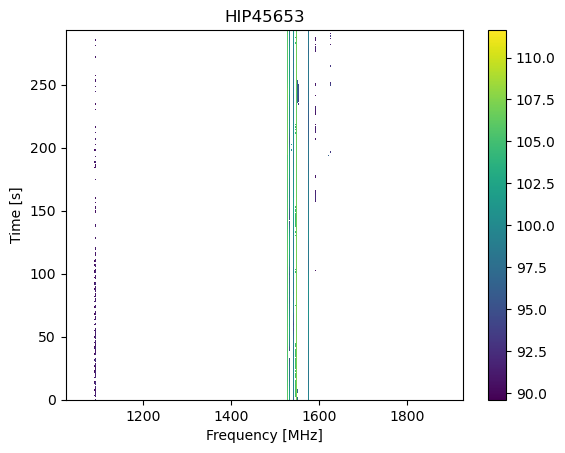

In [4]:
%matplotlib inline
fil.plot_waterfall()
plt.show()

In [5]:
freqs = np.array(fil.freqs)
data = np.array(fil.data)[:,0,:]
time = np.array(fil.timestamps)

print(freqs.shape, data.shape,time.shape)

(315392,) (273, 315392) (273,)


In [6]:
time = time - np.min(time)

In [7]:
import math
def pad_arr(arr, n):
    k = np.floor(math.log2(n))
    k = int(k)
    pa = arr
    for i in range(k):
        pa = np.concatenate((pa,pa))
    print('k =', k);print('remain:',n-2**k)
    print('length of array:',len(pa))
    if n-2**k == 0:
        return pa
    elif n-2**k == 1:
        return np.concatenate((pa,arr))
    else:
        return np.concatenate((pa,pad_arr(arr,n-2**k)))

In [8]:
from minisom import MiniSom
import numpy as np
import pandas as pd

signal = {}
pad_freqs = pad_arr(freqs.flatten(),273)
pad_time = pad_arr(time.flatten(), freqs.shape[0])

print(len(pad_freqs))
print(len(pad_time))

numexpr.utils   INFO     Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils   INFO     NumExpr defaulting to 8 threads.
k = 8
remain: 17
length of array: 80740352
k = 4
remain: 1
length of array: 5046272
k = 18
remain: 53248
length of array: 71565312
k = 15
remain: 20480
length of array: 8945664
k = 14
remain: 4096
length of array: 4472832
k = 12
remain: 0
length of array: 1118208
86102016
86102016


In [9]:
signal['time'] = pad_time
signal['freqs'] = pad_freqs
signal['Flux'] = data.flatten('C')
print(len(signal['Flux']))
print(len(signal['freqs']))
print(len(signal['time']))
df = pd.DataFrame(data = signal)

86102016
86102016
86102016


In [10]:
print(df)

              time        freqs  Flux
0         0.000000  1926.269531   0.0
1         0.000012  1926.266670   0.0
2         0.000025  1926.263809   0.0
3         0.000037  1926.260948   0.0
4         0.000050  1926.258087   0.0
...            ...          ...   ...
86102011  0.003331  1023.940086   0.0
86102012  0.003343  1023.937225   0.0
86102013  0.003355  1023.934364   0.0
86102014  0.003368  1023.931503   0.0
86102015  0.003380  1023.928642   0.0

[86102016 rows x 3 columns]


In [11]:
#df = df.drop(df[df['Flux'] == 0.0].index)
df = (df - np.mean(df, axis=0)) / np.std(df, axis=0)
df = df.values

In [12]:
print(df.shape)

(86102016, 3)


In [13]:
# Initialization and training
som_shape = (1, 4)
som = MiniSom(som_shape[0], som_shape[1], df.shape[1], sigma=.5, learning_rate=.1,
              neighborhood_function='gaussian', random_seed=10)

som.train_batch(df, 10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.8102935960662003


In [14]:
print(som.winner)

<bound method MiniSom.winner of <minisom.MiniSom object at 0x7794da563bc0>>


In [15]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in df]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [16]:
print(cluster_index.shape)

(86102016,)


/tmp/ipykernel_7699/4141548020.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('clustering.pdf')
/tmp/ipykernel_7699/4141548020.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('clustering.pdf')
/home/long/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


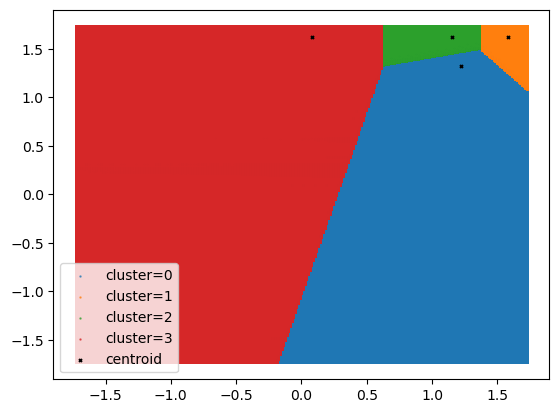

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(df[cluster_index == c, 0],
                df[cluster_index == c, 1], label='cluster='+str(c), s = 0.5, alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=1, linewidths=3, color='k', label='centroid')
plt.legend();
plt.savefig('clustering.pdf')
plt.show()


In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(data[~is_outlier, 0], data[~is_outlier, 1],
            label='inlier')
plt.scatter(data[is_outlier, 0], data[is_outlier, 1],
            label='outlier')
plt.legend()
plt.savefig('resulting_images/som_outliers_detection.png')
plt.show()